# Generate data

Machine ID Conversion Complete
Datetime Conversion Complete
Timestep Feature Addition Complete
Data shape after dropna: (201533, 8)
CPU Usage Column Move Complete


Model is not converging.  Current: -2897423.576253107 is not greater than -2733286.303025729. Delta is -164137.2732273778


Machine ID Conversion Complete
Datetime Conversion Complete
Timestep Feature Addition Complete
Data shape after dropna: (22111, 8)
CPU Usage Column Move Complete


Model is not converging.  Current: -222438.9386619043 is not greater than -176554.4684564676. Delta is -45884.47020543669


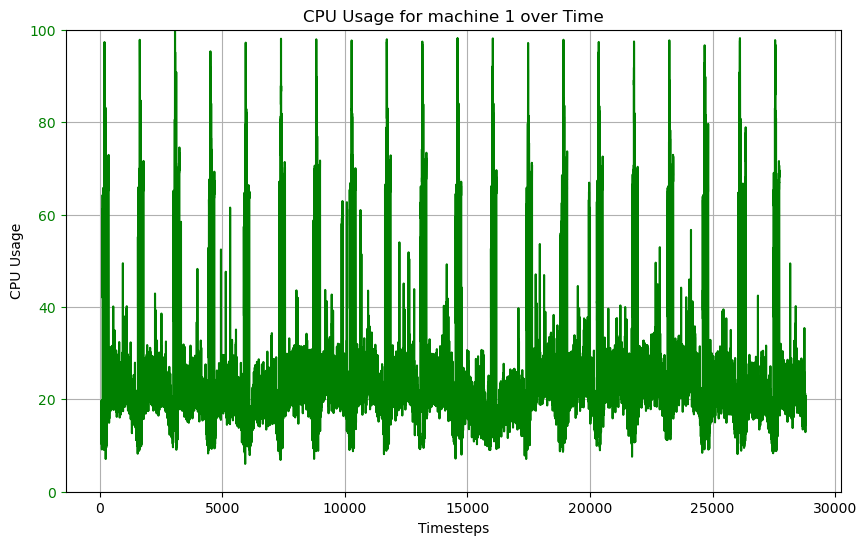

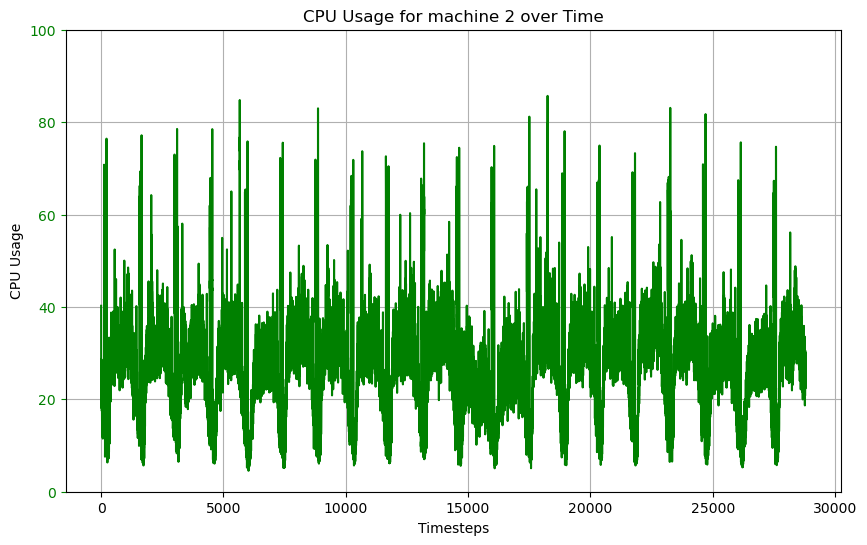

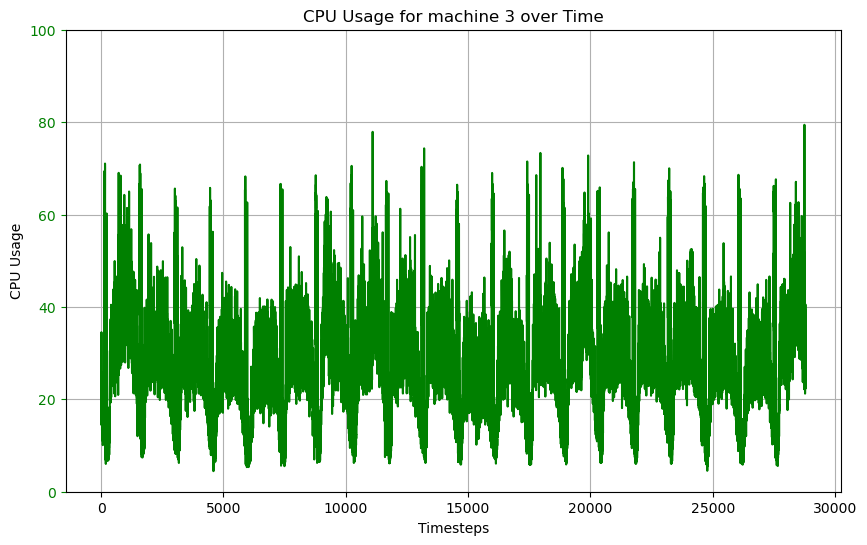

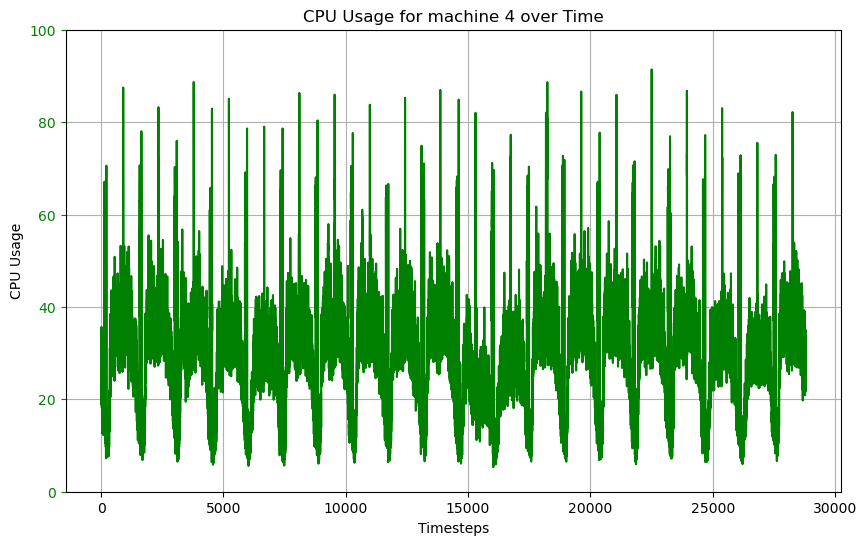

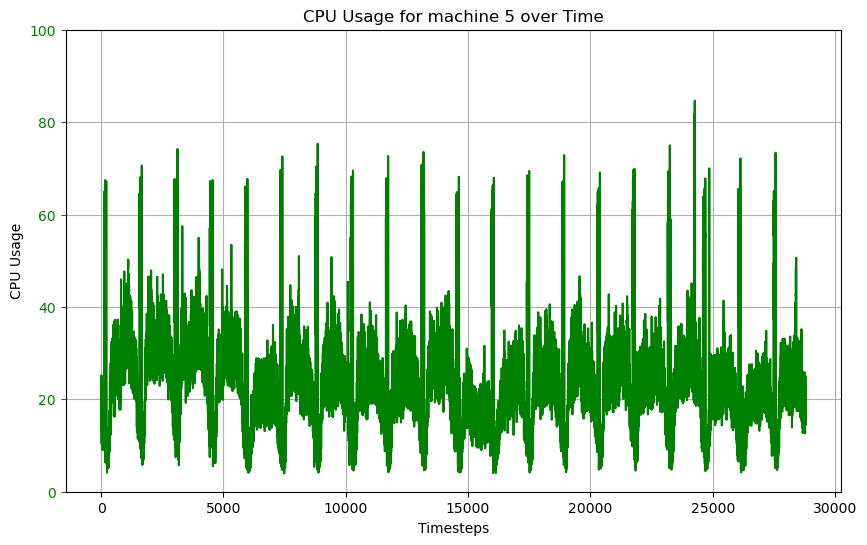

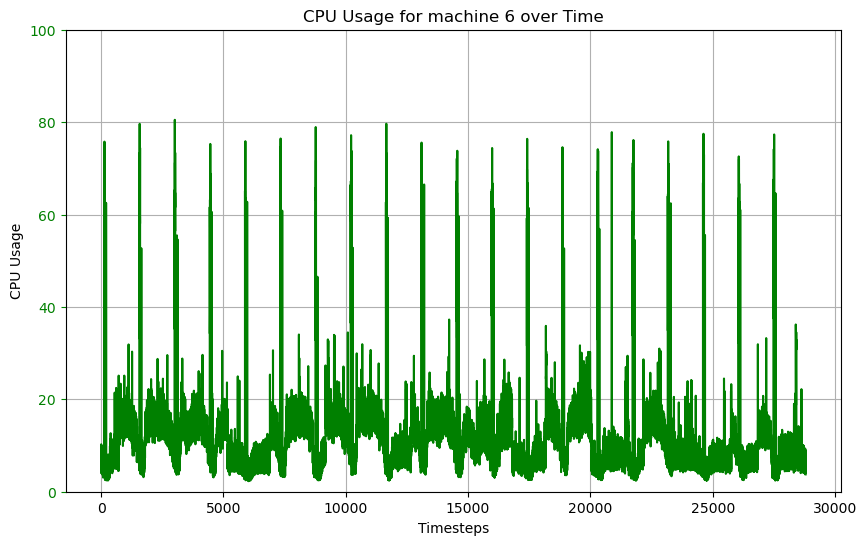

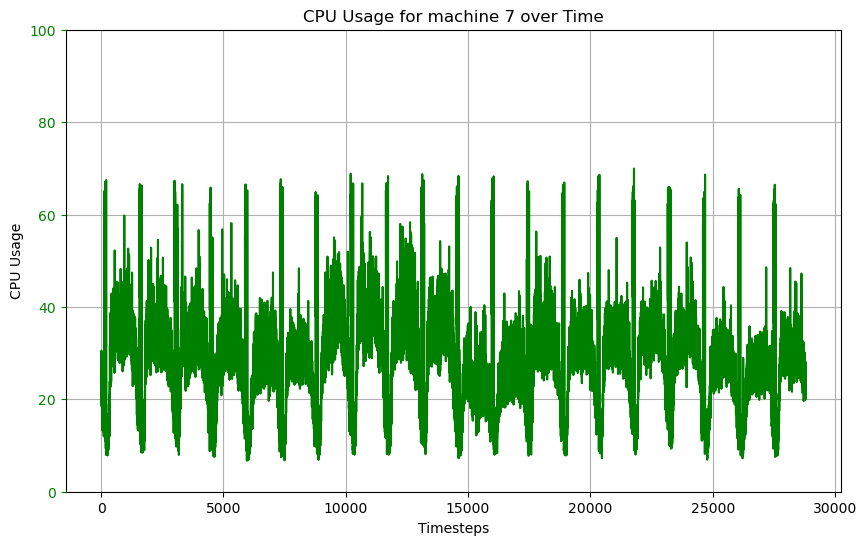

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.optimizers import *
from tensorflow import keras
from sklearn.metrics import *
from datetime import datetime, timedelta
from sklearn.model_selection import *
from scipy import interpolate
import json
from pathlib import Path
from pandas import to_numeric
from hmmlearn import hmm
from keras.losses import *
from dateutil import parser

def convert_datetime_format(datetime_str):
    target_format = "%d/%m/%Y %H:%M"
    try:
        datetime_obj = parser.parse(datetime_str)
        return datetime_obj.strftime(target_format)
    except (ValueError, TypeError):
        print(f"Invalid datetime format: {datetime_str}")
        return None

def insert_missing_minutes(group):
    group = group.sort_values(by='datetime').reset_index(drop=True)
    all_rows = []
    for i in range(len(group) - 1):
        curr_time = group.iloc[i]['datetime']
        next_time = group.iloc[i + 1]['datetime']
        while next_time - curr_time > pd.Timedelta(minutes=1):
            curr_time = curr_time + pd.Timedelta(minutes=1)
            # Insert a new row for the missing minute with NaN for 'value'
            new_row = pd.DataFrame({
                'datetime': [curr_time],
                'machine_id': [group.iloc[i]['machine_id']],
                'cpu_usage': [np.nan]
            })
            all_rows.append(new_row)
    if all_rows:
        group = pd.concat([group] + all_rows).sort_values(by='datetime').reset_index(drop=True)
    return group

def create_time_features(data):
    # Assume 'cpu_data' is your dataframe and 'datetime' is the column with datetime values
    data['datetime'] = pd.to_datetime(data['datetime'])  # Ensure it's a datetime type
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['month'] = data['datetime'].dt.month
    data['day_of_month'] = data['datetime'].dt.day
    data['is_weekend'] = data['datetime'].dt.weekday >= 5  # True for Saturday and Sunday
    return data

# Define a function to create lagged features
def create_additional_features(df, target_col, lags):
    try:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
    except:
        df['datetime'] = df['datetime'].apply(convert_datetime_format)
    df['cpu_usage'].replace(0, np.nan, inplace=True)
    if 'machine_id' in df.columns:
        df['machine_id'] = df['machine_id'].fillna(method='bfill')
        df['machine_id'] = pd.Categorical(df['machine_id']).codes + 1
    else:
        df['machine_id'] = 1
    print("Machine ID Conversion Complete")
    df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M')
    df = df.groupby('machine_id', group_keys=False).apply(insert_missing_minutes)
    df['cpu_usage'] = df.groupby('machine_id', group_keys=False)['cpu_usage'].apply(lambda x: x.interpolate(method='linear', limit_direction='both'))
    print("Datetime Conversion Complete")
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    df['cpu_change'] = df['cpu_usage'].diff() # Change in CPU usage
    df['moving_avg'] = df['cpu_usage'].rolling(window=10).mean() # 10-minute moving average
    print("Timestep Feature Addition Complete")
    # Drop any rows with NaN values that were created due to shifting
    df.dropna(inplace=True)
    print(f"Data shape after dropna: {df.shape}")
    column_to_move = df.pop('cpu_usage')
    df.insert(1, 'cpu_usage', column_to_move)
    print("CPU Usage Column Move Complete")
    df = create_time_features(df)
    all_features_no_timestamp = df.columns[1:len(df.columns)]
    features_for_hmm = df[all_features_no_timestamp].values

    num_states = 10
    model = hmm.GaussianHMM(n_components=num_states, covariance_type="full", n_iter=1000)

    model.fit(features_for_hmm)

    hidden_states = model.predict(features_for_hmm)

    df['hidden_state'] = hidden_states
    return df

cpu_data = pd.read_csv('../Utilities\csv/cpu_usage_data_train.csv')
cpu_data_test = pd.read_csv('../Utilities\csv/cpu_usage_data_test.csv')
lags = [5, 10, 60]
cpu_data = create_additional_features(cpu_data, 'cpu_usage', lags)
cpu_data_test = create_additional_features(cpu_data_test, 'cpu_usage', lags)

file_path = "../Utilities/csv/cpu_usage_train.csv"
cpu_data.to_csv(file_path, index=False)
file_path = "../Utilities/csv/cpu_usage_test.csv"
cpu_data_test.to_csv(file_path, index=False)

for machine_id, machine_data in cpu_data.groupby('machine_id'):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(machine_data['cpu_usage'], 'g-', label='CPU Usage')
    ax.tick_params('y', colors='g')
    plt.xlabel('Timesteps')
    plt.ylabel('CPU Usage')
    ax.set_ylim(0, 100)
    plt.title(f'CPU Usage for machine {machine_id} over Time')
    plt.grid(True)
    plt.show()

# Generate Replicas

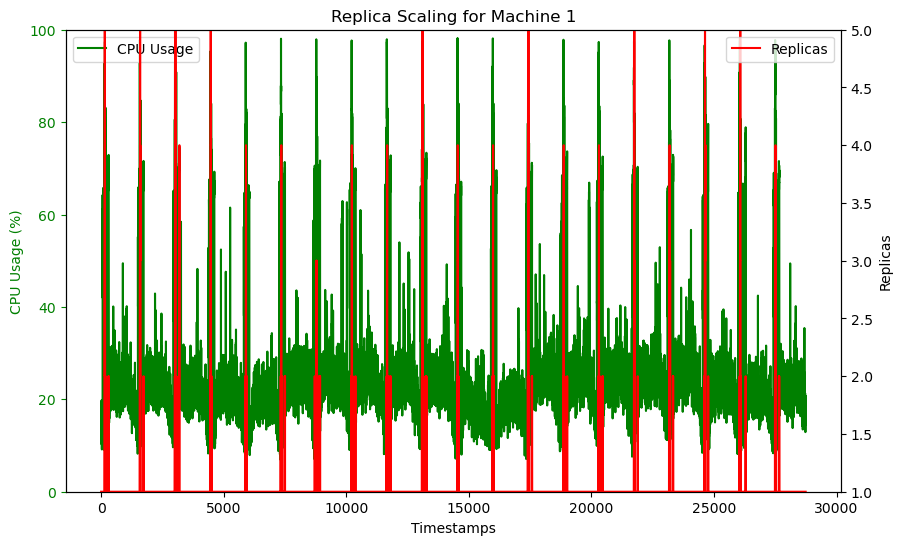

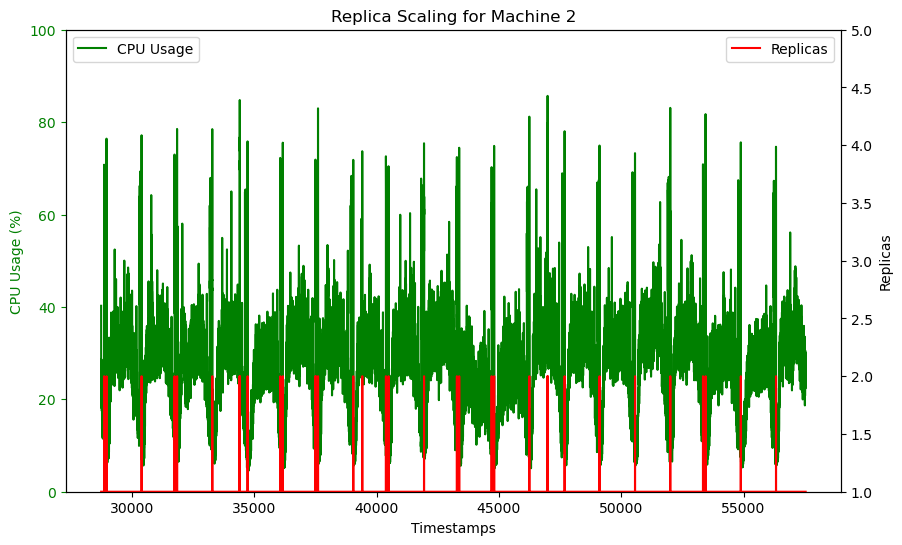

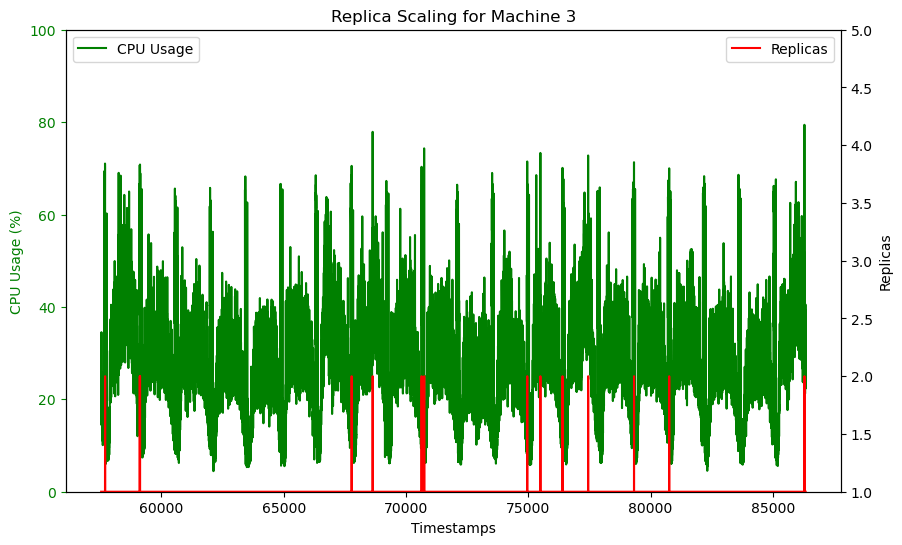

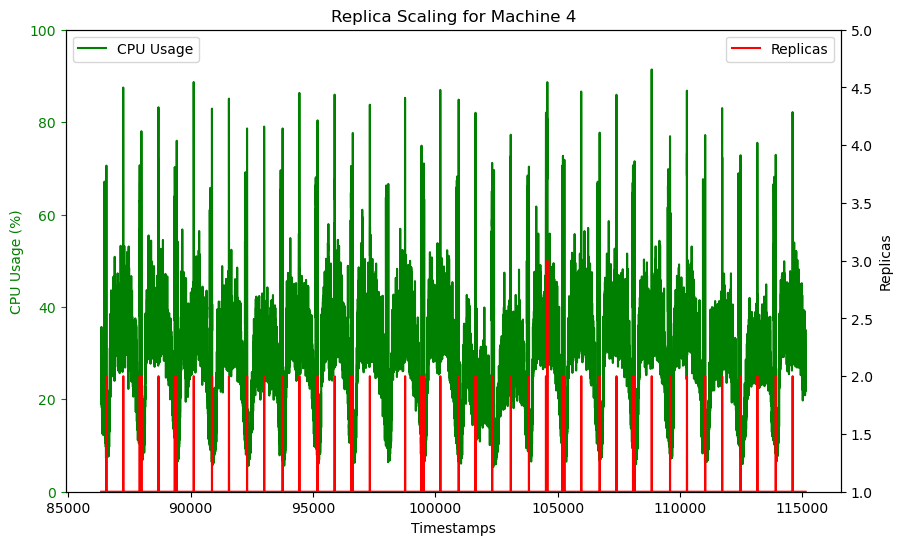

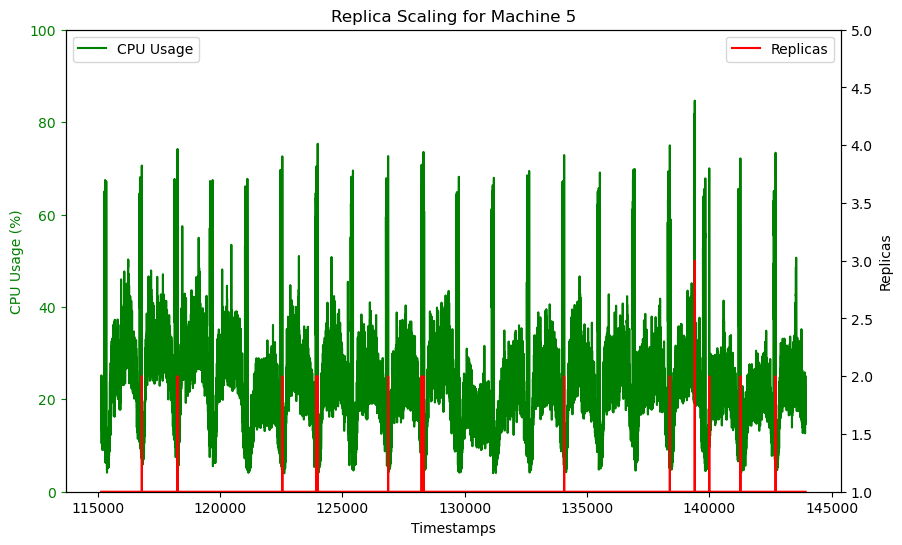

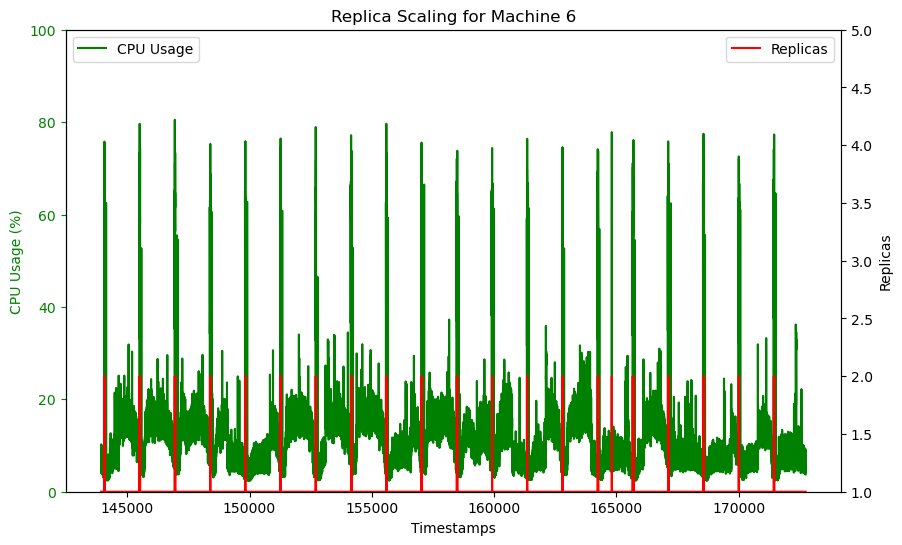

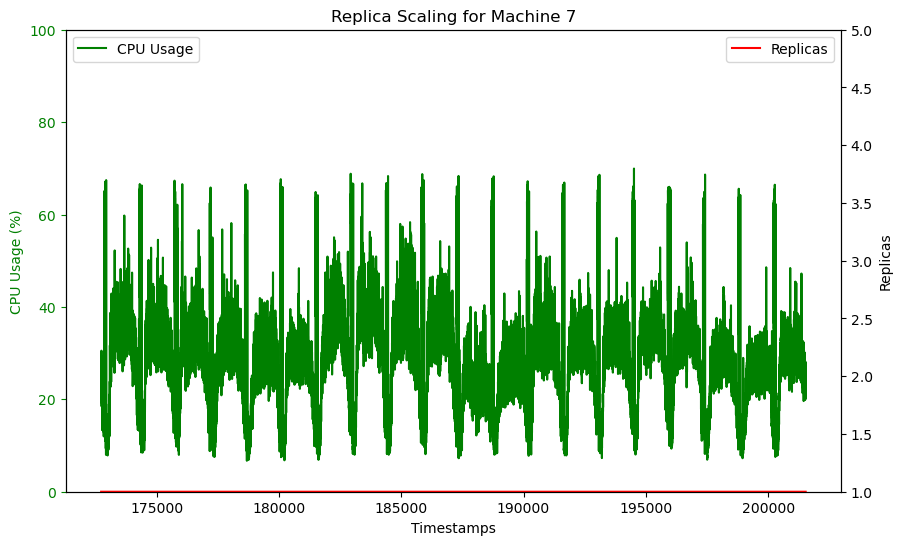

In [3]:
# Variables for tracking cooldown periods and consecutive low CPU usage
scale_up_cooldown = 5  # No scale-up allowed for 5 timesteps after the last scale-up
scale_down_consecutive = 2  # CPU must be below threshold for 2 consecutive timesteps to scale down

initial_replicas = 1
threshold = 70  # SLA threshold at 70%

# Function to generate replicas for each machine separately
def generate_replicas_for_machine(machine_data):
    time_since_last_scale_up = scale_up_cooldown  # Initialize at cooldown to allow immediate scaling if needed
    consecutive_below_threshold = 0  # Track consecutive timesteps below threshold
    current_replicas = initial_replicas  # Start with initial number of replicas

    replicas = []  # List to store the replicas for this machine

    # Iterate through CPU usage data for this machine
    for cpu_usage in machine_data['cpu_usage']:
        # Check if scaling up is allowed
        if cpu_usage >= threshold:
            if time_since_last_scale_up >= scale_up_cooldown:
                current_replicas += 1  # Scale up
                time_since_last_scale_up = 0  # Reset cooldown
            else:
                time_since_last_scale_up += 1  # Increment cooldown timer
            consecutive_below_threshold = 0  # Reset consecutive below counter

        # Check for scaling down
        else:
            consecutive_below_threshold += 1
            if consecutive_below_threshold >= scale_down_consecutive and current_replicas > 1:
                current_replicas -= 1  # Scale down
                consecutive_below_threshold = 0  # Reset consecutive counter
            time_since_last_scale_up += 1  # Continue cooldown for scale up

        # Append the current number of replicas to the list
        replicas.append(current_replicas)

    # Add the 'replicas' column to the machine data
    machine_data['replicas'] = replicas
    return machine_data

# Group by 'machine_id' and apply the replica generation function to each group
cpu_data_with_replicas = cpu_data.groupby('machine_id', group_keys=False).apply(generate_replicas_for_machine)

# Reset the index after applying groupby
cpu_data_with_replicas.reset_index(drop=True, inplace=True)

# Plot replicas and CPU usage for each machine
for machine_id, machine_data in cpu_data_with_replicas.groupby('machine_id', group_keys=False):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    ax1.plot(machine_data['cpu_usage'], 'g-', label='CPU Usage')
    ax1.set_xlabel('Timestamps')
    ax1.set_ylabel('CPU Usage (%)', color='g')
    ax1.tick_params('y', colors='g')
    ax1.set_ylim(0, 100)
    
    ax2 = ax1.twinx()
    ax2.plot(machine_data['replicas'], 'r-', label='Replicas')
    ax2.set_ylabel('Replicas')
    ax2.tick_params('y')
    ax2.set_ylim(1, 5)
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.title(f'Replica Scaling for Machine {machine_id}')
    plt.show()

# Save the dataset with replicas to a CSV file
file_path = "../Utilities/csv/cpu_replicas.csv"
cpu_data_with_replicas.to_csv(file_path, index=False)

# Predict Workload

In [15]:
from keras.optimizers import Adam
# Load your data
cpu_data = pd.read_csv('../Utilities/csv/cpu_usage_train.csv')
cpu_data_test = pd.read_csv('../Utilities/csv/cpu_usage_test.csv')

# Initialize scalers
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Window size (e.g., past 60 time steps) and prediction horizon (next 10 timesteps)
window_size = 60
prediction_horizon = 10

# Function to generate LSTM sequences
def create_lstm_sequences(group_data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        # Features are all columns except 'datetime', 'cpu_usage', and 'machine_id'
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values)
        # Target is the next 10 CPU usage values
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values)
    return np.array(X), np.array(y)

all_features_no_timestamp_cpu_usage = cpu_data.columns[2:len(cpu_data.columns)]
# Scale features and target (fit on the entire dataset)
cpu_data[all_features_no_timestamp_cpu_usage] = feature_scaler.fit_transform(cpu_data[all_features_no_timestamp_cpu_usage])
cpu_data[["cpu_usage"]] = target_scaler.fit_transform(cpu_data[["cpu_usage"]])


all_features_no_timestamp_cpu_usage_test = cpu_data_test.columns[2:len(cpu_data_test.columns)]
# Scale features and target (fit on the entire dataset)
cpu_data_test[all_features_no_timestamp_cpu_usage_test] = feature_scaler.transform(cpu_data_test[all_features_no_timestamp_cpu_usage_test])
cpu_data_test[["cpu_usage"]] = target_scaler.transform(cpu_data_test[["cpu_usage"]])

# Lists to store train/test data
X_train_all, y_train_all = [], []
X_test_all, y_test_all = [], []

# Group by machine_id
for machine_id, group_data in cpu_data.groupby('machine_id'):    
    # Generate moving windows for the training set
    X_train, y_train = create_lstm_sequences(group_data, window_size, prediction_horizon)
    X_train_all.append(X_train)
    y_train_all.append(y_train)
    
for machine_id, group_data in cpu_data_test.groupby('machine_id'):
    # Generate moving windows for the test set
    X_test, y_test = create_lstm_sequences(group_data, window_size, prediction_horizon)
    X_test_all.append(X_test)
    y_test_all.append(y_test)

# Combine all the machine-specific windows together for training and testing
X_train_all = np.concatenate(X_train_all, axis=0)
y_train_all = np.concatenate(y_train_all, axis=0)
X_test_all = np.concatenate(X_test_all, axis=0)
y_test_all = np.concatenate(y_test_all, axis=0)

# Print the shapes of the final train/test data
print("Train shapes:", X_train_all.shape, y_train_all.shape)
print("Test shapes:", X_test_all.shape, y_test_all.shape)

# Build the enhanced CNN-LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_all.shape[1], X_train_all.shape[2])))
# CNN layers
lstm_model.add(Conv1D(filters=230, kernel_size=5, activation='relu'))
lstm_model.add(BatchNormalization())  # Normalize activations
lstm_model.add(Conv1D(filters=115, kernel_size=5, activation='relu'))
lstm_model.add(BatchNormalization())  # Normalize activations
lstm_model.add(MaxPooling1D(pool_size=2))
# LSTM layers
lstm_model.add(LSTM(units=340, return_sequences=True))
lstm_model.add(Dropout(0.2878724963692528))
lstm_model.add(LSTM(units=150, return_sequences=True))
lstm_model.add(Dropout(0.2878724963692528))
lstm_model.add(LSTM(units=50, return_sequences=False))
# Output layer (multi-step prediction)
lstm_model.add(Dense(prediction_horizon))

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_colab.keras', monitor='val_loss', save_best_only=True, mode='min')
# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
optimizer = Adam(learning_rate=0.007269177434065886)
lstm_model.compile(optimizer=optimizer, loss=Huber())  # Use Huber loss to reduce outliers' impact
lstm_model.summary()
# Train the model
history = lstm_model.fit(X_train_all, y_train_all, epochs=50, batch_size=64, validation_data=(X_test_all, y_test_all),
                         verbose=1, callbacks=[early_stopping, model_checkpoint, reduce_lr])

mse_lstm = lstm_model.evaluate(X_test_all, y_test_all)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}")

# Inverse transform the predictions for comparison
y_test_pred_scaled = lstm_model.predict(X_test_all)
y_test_pred = target_scaler.inverse_transform(y_test_pred_scaled)

# Inverse transform the actual values
y_test_actual = target_scaler.inverse_transform(y_test_all)

# Calculate RMSE with unscaled values
final_mse = np.mean((y_test_actual - y_test_pred) ** 2)
final_rmse = np.sqrt(np.mean((y_test_actual - y_test_pred) ** 2))
print(f"RMSE: {final_rmse}, MSE: {final_mse}")

Train shapes: (201050, 60, 11) (201050, 10)
Test shapes: (22042, 60, 11) (22042, 10)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 56, 230)        │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 230)        │           920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 52, 115)        │       132,365 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 52, 115)        │           460 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 26, 115)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 26, 340)        │       620,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 340)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 26, 150)        │       294,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 26, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,102,095 (4.20 MB)

 Trainable params: 1,101,405 (4.20 MB)

 Non-trainable params: 690 (2.70 KB)

Epoch 1/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1321s 415ms/step - loss: 0.0043 - val_loss: 0.0162 - learning_rate: 0.0073
Epoch 2/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1220s 388ms/step - loss: 0.0024 - val_loss: 0.2308 - learning_rate: 0.0073
Epoch 3/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1232s 392ms/step - loss: 0.0024 - val_loss: 0.1311 - learning_rate: 0.0073
Epoch 4/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1264s 386ms/step - loss: 0.0022 - val_loss: 0.0843 - learning_rate: 0.0073
Epoch 5/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1234s 390ms/step - loss: 0.0021 - val_loss: 0.0137 - learning_rate: 0.0036
Epoch 6/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1227s 390ms/step - loss: 0.0020 - val_loss: 0.0168 - learning_rate: 0.0036
Epoch 7/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1274s 388ms/step - loss: 0.0019 - val_loss: 0.0147 - learning_rate: 0.0036
Epoch 8/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1222s 389ms/step - loss: 0.0019 - val_loss: 0.0181 - learning_rate: 0.0036
Epoch 9/50
3142/3142 ━━━━━━━━━━━━━━━━━━━━ 1233s 392ms/step - los

# Forecast prediction

687/687 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step
RMSE: 15.992915153503418, MSE: 255.77333068847656, R-Squared: -0.013696327578073042, MAPE: 144.72902797093104


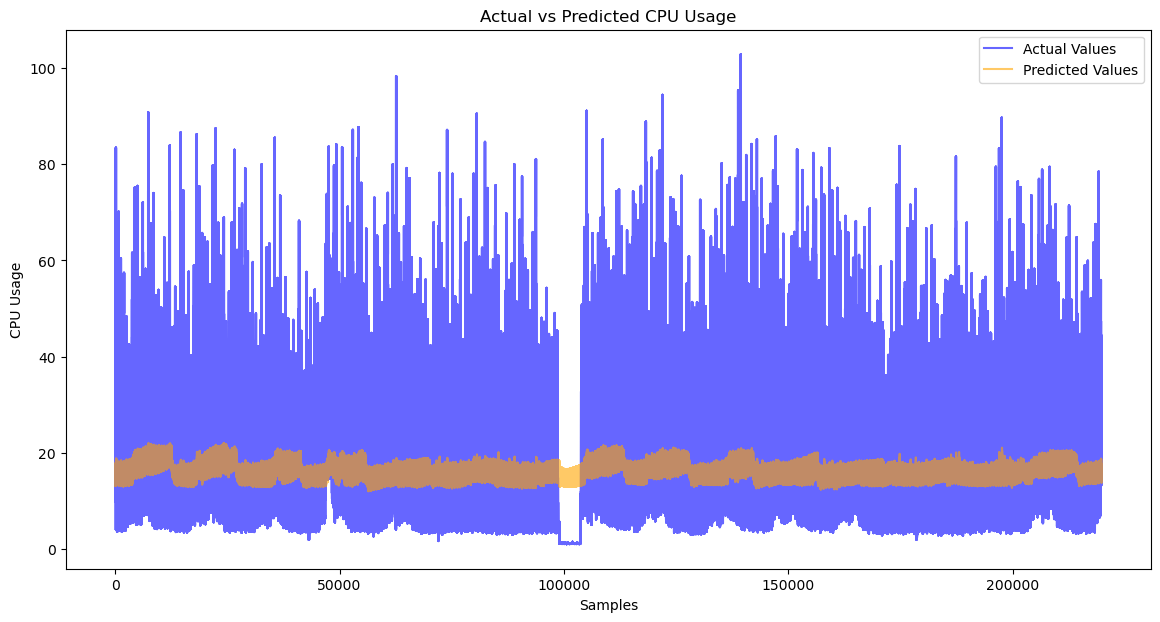

In [8]:
lstm_model = load_model('best_model_2.keras')
# Make predictions
y_pred = lstm_model.predict(X_test)

# Inverse transform the predictions using the target scaler
y_pred_unscaled = target_scaler.inverse_transform(y_pred)

# If `y_test` also needs inverse transforming
y_test_unscaled = target_scaler.inverse_transform(y_test)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_test_rescaled_flat = y_test_unscaled.flatten()
predictions_rescaled_flat = y_pred_unscaled.flatten()

r_squared = r2_score(y_test_rescaled_flat, predictions_rescaled_flat)
mape = mean_absolute_percentage_error(y_test_rescaled_flat, predictions_rescaled_flat)
mse_lstm = mean_squared_error(y_test_rescaled_flat, predictions_rescaled_flat)
rmse_lstm = np.sqrt(mse_lstm)

print(f"RMSE: {rmse_lstm}, MSE: {mse_lstm}, R-Squared: {r_squared}, MAPE: {mape}")
# Plotting Actual vs Predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled_flat, label='Actual Values', color='blue', alpha=0.6)
plt.plot(predictions_rescaled_flat, label='Predicted Values', color='orange', alpha=0.6)
plt.title('Actual vs Predicted CPU Usage')
plt.xlabel('Samples')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

# Predicting number of replicas

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error (MSE): 0.006791290158334831


c:\Users\brand\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


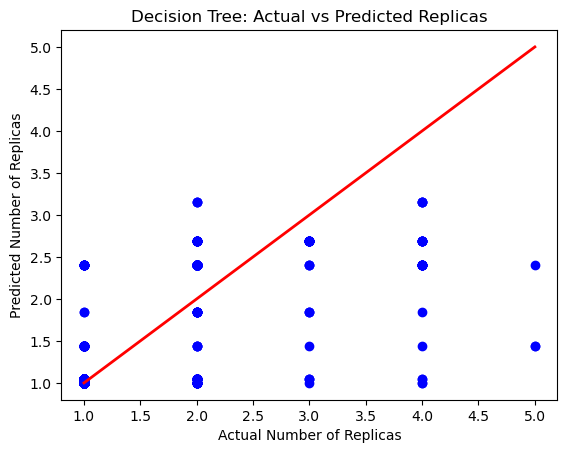

689/689 ━━━━━━━━━━━━━━━━━━━━ 33s 49ms/step
Predicted number of replicas for 10 mins future CPU usage (7.695647716522217): 1.001187625333411


In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

replicas_data = pd.read_csv('../Utilities\csv/cpu_replicas.csv')

# Split the data
X = replicas_data[['cpu_usage']]
y = replicas_data['replicas']
X_train_replicas, X_test_replicas, y_train_replicas, y_test_replicas = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for decision tree
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the model
tree_model = DecisionTreeRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_replicas.values, y_train_replicas.values)

# Best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Predict with the best model
best_model = grid_search.best_estimator_
y_pred_replicas = best_model.predict(X_test_replicas)

# Evaluate the model
mse = mean_squared_error(y_test_replicas, y_pred_replicas)
print(f"Mean Squared Error (MSE): {mse}")

# Plot the results
plt.scatter(y_test_replicas, y_pred_replicas, color='blue')
plt.plot([y_test_replicas.min(), y_test_replicas.max()], [y_test_replicas.min(), y_test_replicas.max()], color='red', lw=2)
plt.xlabel('Actual Number of Replicas')
plt.ylabel('Predicted Number of Replicas')
plt.title('Decision Tree: Actual vs Predicted Replicas')
plt.show()

# Predict using LSTM output
predictions = lstm_model.predict(X_test)
# cpu_usage_scaler = MinMaxScaler()
# cpu_usage_scaler.min_, cpu_usage_scaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

predictions_rescaled = target_scaler.inverse_transform(predictions)

future_replicas = best_model.predict(predictions_rescaled.reshape(-1, 1))
print(f'Predicted number of replicas for 10 mins future CPU usage ({predictions_rescaled[0][-1]}): {future_replicas[0]}')

# Detect Burst

In [9]:
import time
from kubernetes import client, config
import requests
import json
from datetime import datetime, timedelta

def get_time_range():
    end_time = int(time.time())  # Current timestamp in seconds
    start_time = end_time - (3 * 3600) # Hours in seconds
    return start_time, end_time

# Prometheus server URL (adjust according to your setup)
PROMETHEUS_URL = "http://localhost:9090"

def query_prometheus_range(query, start_time, end_time, step):
    params = {
        'query': query,
        'start': start_time,
        'end': end_time,
        'step': step  # Interval between points (e.g., 60s = 1 minute intervals)
    }
    response = requests.get(f"{PROMETHEUS_URL}/api/v1/query_range", params=params)
    return response.json()

# Function to get CPU usage for a pod over the past hour
def get_pod_cpu_usage_range(pod_name, start_time, end_time):
    # Prometheus query to get CPU usage over the last hour (rate over 1 minute)
    query = f'avg((sum(rate(container_cpu_usage_seconds_total{{pod=~"{pod_name}-.*"}}[1m])) by (pod)) / (sum(kube_pod_container_resource_limits{{pod=~"{pod_name}-.*", resource="cpu"}}) by (pod))) * 100'

    # Query Prometheus with a 60-second step interval
    result = query_prometheus_range(query, start_time, end_time, step="60")

    return result

# Function to convert the Prometheus result to a pandas DataFrame
def prometheus_to_dataframe(prometheus_result):
    if not prometheus_result or 'data' not in prometheus_result:
        return pd.DataFrame()  # Return an empty DataFrame if there's no data

    # Extract the 'values' from the first result (assuming only one pod)
    values = prometheus_result['data']['result'][0]['values']

    # Create a DataFrame from the values
    df = pd.DataFrame(values, columns=['datetime', 'value'])

    # Convert UNIX timestamp to human-readable datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='s')

    # Convert the value column to float
    df['value'] = df['value'].astype(float)

    return df

def get_dataset():
    start_time, end_time = get_time_range()
    pod_cpu_data = get_pod_cpu_usage_range("microsvc", start_time, end_time)
    cluster_data_1h = prometheus_to_dataframe(pod_cpu_data)
    cluster_data_1h['datetime'] = pd.to_datetime(cluster_data_1h['datetime']).dt.floor('T')
    lags = [5, 10, 60]
    full_1h_data = create_additional_features(cluster_data_1h, 'cpu_usage', lags)
    full_1h_data.dropna(inplace=True)
    return full_1h_data

window_size = 60
prediction_horizon = 10

def create_lstm_sequences(group_data, window_size, prediction_horizon):
    X, y = [], []
    for i in range(len(group_data) - window_size - prediction_horizon + 1):
        # Features are all columns except 'datetime', 'cpu_usage', and 'machine_id'
        X.append(group_data.iloc[i:i + window_size].drop(columns=['datetime', 'cpu_usage', 'machine_id']).values)
        # Target is the next 10 CPU usage values
        y.append(group_data.iloc[i + window_size:i + window_size + prediction_horizon]['cpu_usage'].values)
    return np.array(X), np.array(y)

# Load kube config
config.load_kube_config()
# If running inside the cluster, use:
# config.load_incluster_config()

def scale_out(additional_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = current_replicas + additional_replicas
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled out to {new_replicas} replicas.")
    return new_replicas

def scale_in(remove_replicas, deployment_name, namespace='default'):
    api = client.AppsV1Api()
    deployment = api.read_namespaced_deployment(deployment_name, namespace)
    current_replicas = deployment.spec.replicas
    new_replicas = max(current_replicas - remove_replicas, 1)
    deployment.spec.replicas = new_replicas
    api.patch_namespaced_deployment(deployment_name, namespace, deployment)
    print(f"Scaled in to {new_replicas} replicas.")
    return new_replicas

def detect_burst(monitoring_interval, window_size, resource_prediction_model, replica_prediction_model, replicas):
    is_burst = False
    replicas_before_burst = 1
    past_predictions = np.array([])
    feature_scaler_burst = MinMaxScaler()
    # while True:
    x = 0
    while x < 5:
        x += 1
        time.sleep(monitoring_interval)
        full_3h_data = get_dataset()
        scaled_data = feature_scaler_burst.fit_transform(full_3h_data)
        # In 10 minute increments
        prediction_steps = 10
        prediction_lookup = 60
        predict_data, predict_labels = create_lstm_sequences(scaled_data, prediction_lookup, prediction_steps)
        cpu_predictions = resource_prediction_model.predict(predict_data)
        predictions_rescaled = feature_scaler_burst.inverse_transform(cpu_predictions)
        n_predicted = replica_prediction_model.predict(predictions_rescaled.reshape(-1, 1))
        past_predictions = np.append(past_predictions, n_predicted)
        sd_max = 0
        n_max = 0
        for i in range(1, window_size + 1):
            sigma_i = np.std(past_predictions)

            if sigma_i > sd_max:
                sd_max = sigma_i
                n_max = max(past_predictions.flatten())

        if sd_max >= 2 and not is_burst:
            # Detected burst, increase replicas to n_max
            replicas_during_burst = n_max
            is_burst = True
            replicas_before_burst = n_predicted  # Store current predicted replicas before burst
        elif sd_max >= 2 and is_burst:
            # Continuation of the burst
            replicas_during_burst = n_max
        elif sd_max < 2 and is_burst:
            if replicas_before_burst > n_predicted:
                # Burst ending, scale back to predicted replicas
                replicas_during_burst = n_predicted
                is_burst = False
                replicas_before_burst = 1
            else:
                # Keep scaling at n_max
                replicas_during_burst = n_max
        else:
            # Normal condition, set replicas to predicted
            replicas_during_burst = n_predicted[0]

        current_replica_count = int(replicas)
        replicas_during_burst = int(replicas_during_burst)

        if current_replica_count < replicas_during_burst:
            additional_replicas = int(replicas_during_burst - current_replica_count)
            replicas = scale_out(additional_replicas, 'microsvc', namespace='default')
        elif current_replica_count > replicas_during_burst:
            replica_difference = int(current_replica_count - replicas_during_burst)
            replicas = scale_in(replica_difference, 'microsvc', namespace='default')
        else:
            print("No replica update needed")
        # Log the updated replica count
        print(f"Updated replica count: {replicas}")


api = client.AppsV1Api()
deployment = api.read_namespaced_deployment('microsvc', namespace='default')
replicas = deployment.spec.replicas
print(f"Original replica count: {replicas}")
lstm_model = load_model('best_model.keras')
detect_burst(60, 10, lstm_model, best_model, replicas)

MaxRetryError: HTTPSConnectionPool(host='kubernetes.docker.internal', port=6443): Max retries exceeded with url: /apis/apps/v1/namespaces/default/deployments/microsvc (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000020F2C5AF9D0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

# Create HPA System

In [ ]:
# import joblib

# joblib.dump(model, 'cpu_usage_predictor.pkl')
# joblib.dump(best_model, 'replicas_predictor.pkl')
